In [1]:
# 멀티모달 예제 1: 이미지 분류 + LLM 설명 생성

# 필요한 라이브러리 설치
!pip install transformers torch torchvision pillow requests matplotlib


In [2]:
# 나눔고딕 폰트 설치 및 설정
!apt-get update -qq
!apt-get install fonts-nanum -qq
!fc-cache -fv
!rm ~/.cache/matplotlib -rf


import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from PIL import Image
import requests
import matplotlib.pyplot as plt
import io
import base64


import matplotlib.font_manager as fm

# 폰트 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=10)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 126374 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no

In [3]:

class ImageClassifier:
    """CNN 기반 이미지 분류기"""

    def __init__(self):
        # 사전 훈련된 ResNet50 모델 로드
        self.model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        self.model.eval()

        # 이미지 전처리
        self.transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

        # ImageNet 클래스 레이블 로드
        self.load_class_labels()

    def load_class_labels(self):
        """ImageNet 클래스 레이블 로드"""
        url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
        try:
            response = requests.get(url)
            self.class_labels = response.text.strip().split('\n')
        except:
            # 백업용 샘플 레이블
            self.class_labels = [f"class_{i}" for i in range(1000)]

    def predict(self, image, top_k=3):
        """이미지 분류 수행"""
        # 이미지 전처리
        input_tensor = self.transform(image).unsqueeze(0)

        # 예측 수행
        with torch.no_grad():
            outputs = self.model(input_tensor)
            probabilities = torch.nn.functional.softmax(outputs[0], dim=0)

        # 상위 k개 결과 반환
        top_prob, top_class = torch.topk(probabilities, top_k)

        results = []
        for i in range(top_k):
            class_idx = top_class[i].item()
            prob = top_prob[i].item()
            label = self.class_labels[class_idx]
            results.append({
                'class': label,
                'probability': prob,
                'confidence': f"{prob*100:.2f}%"
            })

        return results

class DescriptionGenerator:
    """GPT-2 기반 설명 생성기"""

    def __init__(self):
        # GPT-2 모델과 토크나이저 로드
        self.tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
        self.model = GPT2LMHeadModel.from_pretrained('gpt2')

        # 패딩 토큰 설정
        self.tokenizer.pad_token = self.tokenizer.eos_token

    def generate_description(self, classification_results, max_length=150):
        """분류 결과를 바탕으로 설명 생성"""
        # 프롬프트 생성
        top_class = classification_results[0]['class']
        confidence = classification_results[0]['confidence']

        prompt = f"This image shows a {top_class} with {confidence} confidence. "

        # 토큰화
        inputs = self.tokenizer.encode(prompt, return_tensors='pt')

        # 텍스트 생성
        with torch.no_grad():
            outputs = self.model.generate(
                inputs,
                max_length=max_length,
                num_return_sequences=1,
                temperature=0.7,
                pad_token_id=self.tokenizer.eos_token_id,
                do_sample=True
            )

        # 디코딩
        generated_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        description = generated_text[len(prompt):].strip()

        return description

class MultimodalSystem:
    """멀티모달 통합 시스템"""

    def __init__(self):
        print("🚀 멀티모달 시스템 초기화 중...")
        self.classifier = ImageClassifier()
        self.generator = DescriptionGenerator()
        print("✅ 시스템 초기화 완료!")

    def analyze_image(self, image_path_or_url):
        """이미지 분석 및 설명 생성"""
        # 이미지 로드
        if image_path_or_url.startswith('http'):
            response = requests.get(image_path_or_url)
            image = Image.open(io.BytesIO(response.content)).convert('RGB')
        else:
            image = Image.open(image_path_or_url).convert('RGB')

        # 이미지 분류
        print("🔍 이미지 분류 중...")
        classification_results = self.classifier.predict(image)

        # 설명 생성
        print("📝 설명 생성 중...")
        description = self.generator.generate_description(classification_results)

        # 결과 시각화
        self.display_results(image, classification_results, description)

        return {
            'classification': classification_results,
            'description': description
        }

    def display_results(self, image, classification_results, description):
        """결과 시각화"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # 이미지 표시
        ax1.imshow(image)
        ax1.axis('off')
        ax1.set_title('입력 이미지', fontsize=14, fontweight='bold')

        # 분류 결과 표시
        ax2.axis('off')
        results_text = "🎯 분류 결과:\n\n"
        for i, result in enumerate(classification_results):
            results_text += f"{i+1}. {result['class']}\n   신뢰도: {result['confidence']}\n\n"

        results_text += f"📖 AI 생성 설명:\n\n{description}"

        ax2.text(0.05, 0.95, results_text, transform=ax2.transAxes,
                fontsize=11, verticalalignment='top', wrap=True,
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))

        plt.tight_layout()
        plt.show()

# 시스템 초기화
system = MultimodalSystem()

# 테스트 실행
print("=" * 50)
print("🌟 멀티모달 이미지 분석 시스템 테스트")
print("=" * 50)

# 샘플 이미지 URL들 (무료 사용 가능한 이미지)
sample_images = [
    "https://upload.wikimedia.org/wikipedia/commons/thumb/4/47/American_Eskimo_Dog.jpg/440px-American_Eskimo_Dog.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/thumb/d/d9/Collage_of_Nine_Dogs.jpg/440px-Collage_of_Nine_Dogs.jpg"
]

# 첫 번째 이미지 분석
try:
    print("\n🖼️ 첫 번째 이미지 분석:")
    result1 = system.analyze_image(sample_images[0])

    print(f"\n📊 분석 결과:")
    print(f"주요 분류: {result1['classification'][0]['class']}")
    print(f"신뢰도: {result1['classification'][0]['confidence']}")
    print(f"생성된 설명: {result1['description']}")

except Exception as e:
    print(f"❌ 오류 발생: {e}")
    print("💡 로컬 이미지 파일을 사용해보세요:")
    print("   result = system.analyze_image('your_image_path.jpg')")

print("\n" + "=" * 50)
print("🎉 멀티모달 시스템 테스트 완료!")
print("💡 사용법: system.analyze_image('이미지_경로_또는_URL')")
print("=" * 50)

🚀 멀티모달 시스템 초기화 중...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


✅ 시스템 초기화 완료!
🌟 멀티모달 이미지 분석 시스템 테스트

🖼️ 첫 번째 이미지 분석:
❌ 오류 발생: cannot identify image file <_io.BytesIO object at 0x7ed3e17fe020>
💡 로컬 이미지 파일을 사용해보세요:
   result = system.analyze_image('your_image_path.jpg')

🎉 멀티모달 시스템 테스트 완료!
💡 사용법: system.analyze_image('이미지_경로_또는_URL')


🔍 이미지 분류 중...


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


📝 설명 생성 중...


/tmp/ipython-input-105403131.py:151: UserWarning: Glyph 51077 (\N{HANGUL SYLLABLE IB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-105403131.py:151: UserWarning: Glyph 47141 (\N{HANGUL SYLLABLE RYEOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-105403131.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-105403131.py:151: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-105403131.py:151: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-105403131.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-105403131.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipyth

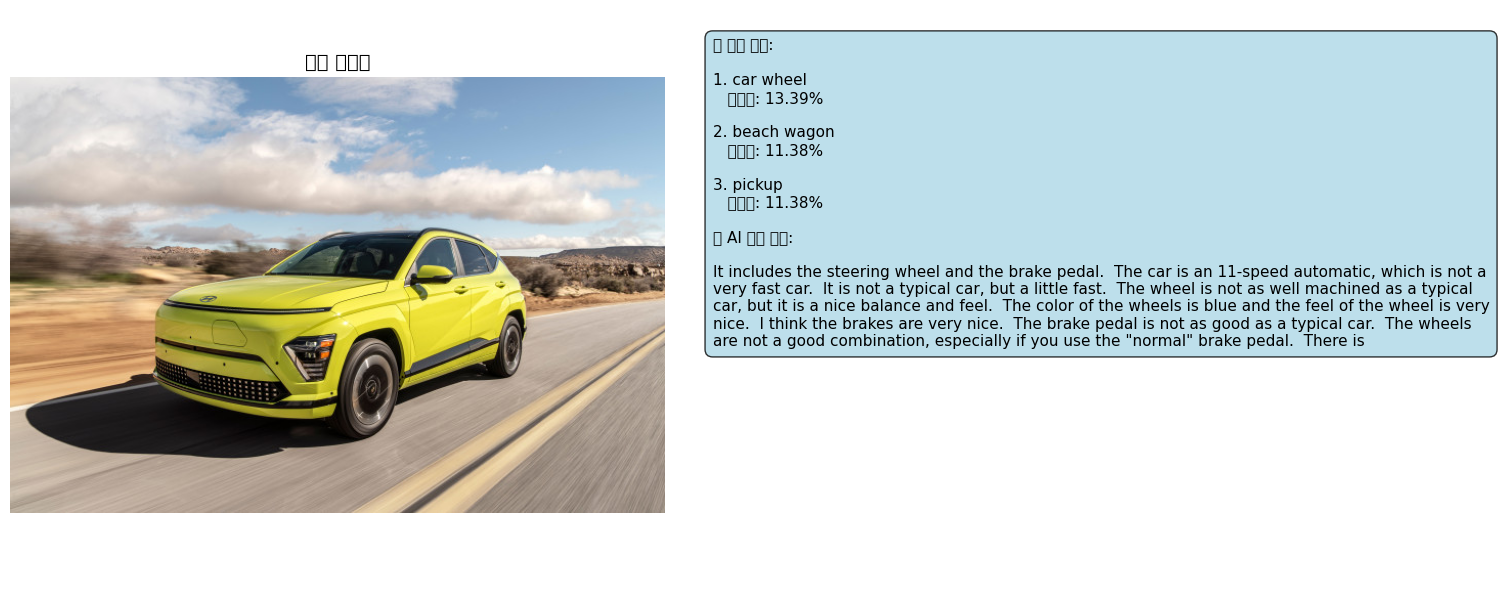

{'classification': [{'class': 'car wheel',
   'probability': 0.13387978076934814,
   'confidence': '13.39%'},
  {'class': 'beach wagon',
   'probability': 0.1138349324464798,
   'confidence': '11.38%'},
  {'class': 'pickup',
   'probability': 0.11380013823509216,
   'confidence': '11.38%'}],
 'description': 'It includes the steering wheel and the brake pedal. \xa0The car is an 11-speed automatic, which is not a very fast car. \xa0It is not a typical car, but a little fast. \xa0The wheel is not as well machined as a typical car, but it is a nice balance and feel. \xa0The color of the wheels is blue and the feel of the wheel is very nice. \xa0I think the brakes are very nice. \xa0The brake pedal is not as good as a typical car. \xa0The wheels are not a good combination, especially if you use the "normal" brake pedal. \xa0There is'}

In [4]:
system.analyze_image('https://file.newswire.co.kr/data/datafile2/thumb_640/2023/12/1028147215_20231213114838_5550752674.jpg')